In [10]:
from OpInf import *
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

from scipy.io import loadmat
from operators import ckron, ckron_indices

import scienceplots
plt.style.use(["science", "no-latex", "grid"])

In [2]:
import numpy as np
from scipy.optimize import least_squares


def polynomial_form(x, p):
    """Polynomial representation of the reduced state snapshot data."""
    return [x**degree for degree in range(2, p+1)]



def relative_error(S_exact, S_reconstructed, Sref):
    """Calculate the relative squared Frobenius-norm error."""
    return np.linalg.norm(S_exact - S_reconstructed, 'fro') / np.linalg.norm(S_exact - Sref, 'fro')



def representation_learning_obj(x, snapshot_index, Vr, Vbar, Xi, S, sref, p=2):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ np.concatenate(polynomial_form(x, p), axis=0))



def alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    # Define additional functions required for optimization here
    # e.g., polynomial_form(x), representation_learning_obj(x), etc.
    
    U, _, _ = np.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    
    # Initialize Shat and other variables
    if initial_Shat:
        Shat = initial_Shat
    
    else:
        Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    for niter in range(max_iter):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = np.linalg.svd((S - Sref) @ np.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = np.linalg.inv(Poly @ Poly.T + (gamma * np.identity((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        # Step 3 - Nonlinear regression (update reduced state representation)
        for snapshot in range(num_snapshots):
            
            # Shat[:, snapshot] = least_squares(lambda x: representation_learning_obj(x, snapshot, Vr, Vbar, Xi, S, sref, p=p), Shat[:, snapshot], ftol=1e-9).x
            Shat[:, snapshot] = least_squares(representation_learning_obj, Shat[:, snapshot], args=(snapshot, Vr, Vbar, Xi, S, sref, p), ftol=1e-9).x
        Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)

        # Evaluate convergence criterion
        energy = np.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

# To call this function, you would need to prepare all the required arguments first.
# For example:
# Shat_optimized, final_energy = alternating_minimization(S, Sref, num_snapshots, max_iter, tol, initial_Shat, gamma, r, q, p)


In [3]:
mus = [1.1, 1.05, 1, 0.95, 0.9]
# Load data

p = 2
Mp = len(mus)
dt = 1e-3
T_end = 2

config = {
    "N": 2**7 + 1 + 1,
    "dt": 1e-3,
    "T_end": T_end,
    "mus": list(mus),
    "Mp": Mp,
    "K": T_end / dt,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQCP",
        "modeltime": "continuous",
        "dt": dt,
        "ddt_order": "BE",
        "p": p, # polynomial order
        "lambda1": 5e-2,
        "lambda2": 5e-2,
        "lambda3": 100,
    },
    "type": "single"
}




In [4]:
Train_T = int(T_end/dt)
X_all = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")[:, :Train_T+1, :]
# X_all = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE100.npy")
print(X_all.shape)

(5, 2001, 130)


In [5]:
import numpy as np
from scipy.optimize import least_squares

def polynomial_form(x, p):
    """Polynomial representation of the reduced state snapshot data."""
    return [x**degree for degree in range(2, p+1)]


def relative_error(S_exact, S_reconstructed, Sref):
    """Calculate the relative squared Frobenius-norm error."""
    return np.linalg.norm(S_exact - S_reconstructed, 'fro') / np.linalg.norm(S_exact - Sref, 'fro')


def representation_learning_obj(x, snapshot_index, Vr, Vbar, Xi, S, sref, p=2):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ np.concatenate(polynomial_form(x, p), axis=0))


def representation_learning_obj_jax(x, snapshot_index, Vr, Vbar, Xi, S, sref):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ jnp.concatenate(polynomial_form(x, 2), axis=0))


def alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    # Define additional functions required for optimization here
    # e.g., polynomial_form(x), representation_learning_obj(x), etc.
    
    U, _, _ = np.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    
    # Initialize Shat and other variables
    if initial_Shat:
        Shat = initial_Shat
    
    else:
        Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    for niter in range(max_iter):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = np.linalg.svd((S - Sref) @ np.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = np.linalg.inv(Poly @ Poly.T + (gamma * np.identity((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        # Step 3 - Nonlinear regression (update reduced state representation)
        for snapshot in range(num_snapshots):
            
            # Shat[:, snapshot] = least_squares(lambda x: representation_learning_obj(x, snapshot, Vr, Vbar, Xi, S, sref, p=p), Shat[:, snapshot], ftol=1e-9).x
            Shat[:, snapshot] = least_squares(representation_learning_obj, Shat[:, snapshot], args=(snapshot, Vr, Vbar, Xi, S, sref, p), ftol=1e-9).x
        Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)

        # Evaluate convergence criterion
        energy = np.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

from jaxopt import GaussNewton, LevenbergMarquardt
from jax import jit, vmap
import jax
import jax.numpy as jnp

def nonlinear_regression_step(snapshot_index, Shat, Vr, Vbar, Xi, S, sref):
    """Nonlinear regression step for a single snapshot."""
    LM = LevenbergMarquardt(residual_fun=representation_learning_obj_jax, tol=1e-9)
    initial_guess = Shat[:, snapshot_index]
    return LM.run(init_params=initial_guess, snapshot_index=snapshot_index, Vr=Vr, Vbar=Vbar, Xi=Xi, S=S, sref=sref).params

def alternating_minimization_jax(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    S = jnp.array(S)
    Sref = jnp.array(Sref)
    
    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    # Define additional functions required for optimization here
    # e.g., polynomial_form(x), representation_learning_obj(x), etc.
    
    U, _, _ = jnp.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    
    # Initialize Shat and other variables
    if initial_Shat:
        Shat = initial_Shat
    
    else:
        Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = jnp.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ jnp.linalg.inv(Poly @ Poly.T + gamma * jnp.identity((p - 1)*r))
    
    for niter in range(max_iter):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = jnp.linalg.svd((S - Sref) @ jnp.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = jnp.linalg.inv(Poly @ Poly.T + (gamma * jnp.identity((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        
        # Step 3 - Nonlinear regression (update reduced state representation)
        Shat = vmap(nonlinear_regression_step, in_axes=[0, None, None, None, None, None, None])(jnp.arange(num_snapshots), Shat, Vr, Vbar, Xi, S, sref).T
        # Shat = jnp.array(Shat)
        # for snapshot in range(num_snapshots):
        #     Shat[:, snapshot] = opt.least_squares(lambda x: representation_learning_obj(x, snapshot), Shat[:, snapshot], ftol=1e-9, ).x
        #     # Shat = Shat.at[:, snapshot].set(opt.least_squares(representation_learning_obj, Shat[:, snapshot], ftol=1e-9).x)
        Poly = jnp.concatenate(polynomial_form(Shat, p=p), axis=0)

        # Evaluate convergence criterion
        energy = jnp.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / jnp.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

In [6]:
import numpy as np

def ddt(X, dt, scheme):
    """
    Uses specified difference scheme to approximate dX/dt with uniform time spacing of size dt.
    
    Parameters:
    X (np.array): N-by-K data matrix where each column is the state at one time.
    dt (float): Time step.
    scheme (str): Specifies which scheme is used to approximate time derivative.
    
    Returns:
    tuple: Tuple containing:
        - np.array: N-by-M data matrix of state time derivatives.
        - np.array: M-by-1 vector of indices of state data in X.
    """
    
    N, K = X.shape

    if scheme in [1, 'FE']:  # Forward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(K - 1)
    elif scheme == 'BE':  # Backward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(1, K)
    elif scheme in [2, '2c']:  # 2nd order central differencing
        dXdt = (X[:, 2:] - X[:, :-2]) / (2 * dt)
        ind = np.arange(1, K - 1)
    elif scheme == '2imp':  # 2nd order backward differencing (implicit)
        dXdt = (3 * X[:, 2:] - 4 * X[:, 1:-1] + X[:, :-2]) / (2 * dt)
        ind = np.arange(2, K)
    elif scheme == '2ex':  # 2nd order forward differencing (explicit)
        dXdt = (-3 * X[:, :-2] + 4 * X[:, 1:-1] - X[:, 2:]) / (2 * dt)
        ind = np.arange(K - 2)
    elif scheme in [4, '4c']:  # 4th order central differencing
        dXdt = (X[:, :-4] - 8 * X[:, 1:-3] + 8 * X[:, 3:-1] - X[:, 4:]) / (12 * dt)
        ind = np.arange(2, K - 2)
    elif scheme == '4imp':  # 4th order backward differencing
        dXdt = (25 / 12 * X[:, 4:] - 4 * X[:, 3:-1] + 3 * X[:, 2:-2] - 4 / 3 * X[:, 1:-3] + 1 / 4 * X[:, :-4]) / dt
        ind = np.arange(4, K)
    elif scheme == '4ex':  # 4th order forward differencing
        dXdt = (-25 / 12 * X[:, :-4] + 4 * X[:, 1:-3] - 3 * X[:, 2:-2] + 4 / 3 * X[:, 3:-1] - 1 / 4 * X[:, 4:]) / dt
        ind = np.arange(K - 4)
    else:
        raise ValueError('Specified difference scheme not implemented')

    return dXdt, ind

# Note: Function calls are commented out to adhere to instructions. They should be uncommented for testing purposes.
# Example of function call (commented out):
# X = np.random.rand(10, 5)  # Example



def rhs(t, state, operators, params, input_func=None, multi_indices=None):
    r"""Evaluate the right-hand side of the model by applying each operator
    and summing the results.

    This is the function :math:`\Ophat(\qhat, \u)`
    where the model can be written as one of the following:

    * :math:`\ddt\qhat(t) = \Ophat(\qhat(t), \u(t))` (continuous time)
    * :math:`\qhat_{j+1} = \Ophat(\qhat_j, \u_j)` (discrete time)
    * :math:`\widehat{\mathbf{g}} = \Ophat(\qhat, \u)` (steady state)

    Parameters
    ----------
    state : (r,) ndarray
        State vector.
    input_ : (m,) ndarray or None
        Input vector corresponding to the state.

    Returns
    -------
    evaluation : (r,) ndarray
        Evaluation of the right-hand side of the model.
    """
    state = np.atleast_1d(state)
    modelform = params['modelform']
    
    # print("State shape: ", state.shape)
    
    out = np.zeros(state.shape, dtype=float)
    # gs = gen_poly(state[:, None], p=2)  # Assuming gen_poly is designed for column vector input
    
    # print("Solving for regularization parameters: ", params['lambda1'], params['lambda2'], params['lambda3'])
    
    if 'L' in modelform:
        # print("adding A")
        out += operators['A'] @ state
    
    if 'Q' in modelform:
        # ssq = get_x_sq(state[:, None].T).T  # Assuming get_x_sq can handle the shape
        # out += operators['F'] @ ssq.flatten()
        # print("adding F")
        mask = ckron_indices(state.shape[0])
        out += (operators["F"] @ np.prod(state[mask], axis=1))
        
    if 'P' in modelform:
        gs = gen_poly(state[:, None], p=p, multi_indices=multi_indices)  # Assuming gen_poly is designed for column vector input
        out += (operators['P'] @ gs).flatten()
        
    if 'C' in modelform:
        out += operators['C'].flatten()
    
    return out


In [18]:
# err_tols = [1e-2, 1e-3, 1e-4, 1e-5]
err_tols = [1e-1, 5e-2, 1e-2, 1e-3, 1e-4, 1e-5]
max_idx_lst = []
# mus = [0.01] # only one mu for now
for err_tol in err_tols:
    rob_lst = []
    rel_err_SVD_lst = []
    idx_lst = []
    # for i in range(len(X_all)):
        
    X = np.concatenate([X_all[i, :, :] for i in range(Mp)], axis=0).T
    
    # X_ref is the reference state which is just defined as the mean of the snapshots 
    # X_ref = np.mean(X, axis=1)[:, None]
    X_ref = np.zeros((X.shape[0], 1))
    
    # print("X = ", X.shape)
    # print("X_ref = ", X_ref.shape)
    
    # svd
    U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
    # print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (len(S) - 1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0] + 1
    idx_lst.append(idx)
        

    print("max idx = ", max(idx_lst))
    max_idx_lst.append(max(idx_lst))

max idx =  2
max idx =  3
max idx =  5
max idx =  12
max idx =  32
max idx =  50
max idx =  61


In [8]:
# rob_lst = []
# rel_err_SVD_lst = []
# idx_lst = []
# names = [f'Nominal RE100', f'p1per RE100', f'n1per RE100', f'p5per RE100', f'n5per RE100']

# fig, ax = plt.subplots(figsize=(6, 4.5))

# err_tol = 1e-4

# # mus = [0.01] # only one mu for now

# for i in range(len(X_all)):
    
#     X = X_all[i]
    
#     # X_ref is the reference state which is just defined as the mean of the snapshots 
#     # X_ref = np.mean(X, axis=1)[:, None]
#     X_ref = np.zeros((X.shape[0], 1))
    
#     print("X = ", X.shape)
#     print("X_ref = ", X_ref.shape)
    
#     # svd
#     U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
#     print("S = ", S[:5])
#     eigvals_SVD = S**2 * (1 / (len(S) - 1))
#     # print("eigvals_SVD = \n", eigvals_SVD[:5])
#     # append U
#     # print("U = ", U.shape)
#     rob_lst.append(U)
    
#     # calculate the relative error
#     rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
#     rel_err_SVD_lst.append(rel_err_SVD)
#     # print("rel_err_SVD = \n", rel_err_SVD[:4])

#     # print the first idx when it is less than 1e-4
#     idx = np.where(rel_err_SVD < err_tol)[0][0]
#     idx_lst.append(idx)
#     print("idx = ", idx)
#     print("rel_err_SVD[idx] = ", rel_err_SVD[idx])
    
#     ax.plot(rel_err_SVD_lst[i], label=names[i], linestyle='-', alpha=0.7)
#     ax.plot(idx, rel_err_SVD[idx], 'ro', label=f"{err_tol} at r={idx}")
#     ax.set_yscale('log')
#     ax.set_ylabel("$\epsilon$ (log scale)")
#     # set limit
#     ax.set_xlim([0, 200])
#     # ax.set_ylim([1e-13, 1e-3])
#     # show grid
#     ax.grid(True, alpha=0.2)
#     ax.set_xlabel("Rank r")
#     ax.set_title("Relative error, Nominal $\mu = 0.01$")
#     ax.legend()

In [9]:
# p = 3

jax.config.update('jax_platform_name', 'cpu')

tol = 1e-4      # tolerence for alternating minimization
gamma = 0.001       # regularization parameter
max_iter = 100  # maximum number of iterations

Vr_lst = []
Vbar_lst = []
Shat_lst = []
Xi_lst = []
Poly_lst = []

energy_list = []

for i in range(len(err_tols)):
    # print(i)
    # Model parameters
    print("Error Tolerance: ", err_tols[i])
    r = max_idx_lst[i]
    print("r is: ", r)
    q_trunc = 16
    
    # Procustes problem for each mu
    X = np.concatenate([X_all[i, :, :] for i in range(Mp)], axis=0).T
    num_snapshots = X.shape[1]
    print("num_snapshots: ", num_snapshots)
    # print("X = ", X.shape)
    # X_ref = np.mean(X, axis=1)[:, None]
    X_ref = np.zeros((X.shape[0]))[:, None]
    X_centered = X - X_ref

    U, S, Vr = np.linalg.svd(X_centered, full_matrices=False)
    
    Vr = U[:, :r]
    Vbar = U[:, r:r+q_trunc]
    q = Vr.T @ X_centered
    Proj_error = X_centered - (Vr @ q)
    Poly = np.concatenate(polynomial_form(q, p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))

    Gamma_MPOD = X_ref + (Vr @ q) + (Vbar @ Xi @ Poly)
    print(f"Reconstruction error: {relative_error(X, Gamma_MPOD, X_ref):.4%}")
    
    energy = np.linalg.norm(Vr @ q + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(X - X_ref, 'fro')**2
    print(f"Energy: {energy:.4e}")
    print("\n")
    
    # q, energy, Xi, Vr, Vbar, Poly = alternating_minimization(X, X_ref, num_snapshots, max_iter, tol, gamma, r, q_trunc, p, initial_Shat=None)
    # q, energy, Xi, Vr, Vbar, Poly = alternating_minimization_jax(X, X_ref, num_snapshots, max_iter, 1e-3, gamma, r, q_trunc, p, initial_Shat=None)
    
    energy_list.append(energy)
    Vr_lst.append(Vr)
    Vbar_lst.append(Vbar)
    Shat_lst.append(q)
    Xi_lst.append(Xi)
    Poly_lst.append(Poly)


    # print("q = ", q.shape)
    # print("qbar = ", qbar.shape)

Error Tolerance:  0.1
r is:  3
num_snapshots:  10005


Reconstruction error: 25.1460%
Energy: 9.3677e-01


Error Tolerance:  0.05
r is:  5
num_snapshots:  10005
Reconstruction error: 16.7316%
Energy: 9.7201e-01


Error Tolerance:  0.01
r is:  12
num_snapshots:  10005
Reconstruction error: 7.4744%
Energy: 9.9441e-01


Error Tolerance:  0.001
r is:  32
num_snapshots:  10005
Reconstruction error: 2.2819%
Energy: 9.9948e-01


Error Tolerance:  0.0001
r is:  50
num_snapshots:  10005
Reconstruction error: 0.7179%
Energy: 9.9995e-01


Error Tolerance:  1e-05
r is:  61
num_snapshots:  10005
Reconstruction error: 0.2401%
Energy: 9.9999e-01




In [11]:
# save energy list
with open("OpInfPoly_energy_lst.pkl", "wb") as f:
    pickle.dump(energy_list, f)

In [10]:
Gamma_MPOD = X_ref + (Vr @ q) + (Vbar @ Xi @ Poly)
print(f"\nReconstruction error: {relative_error(X, Gamma_MPOD, X_ref):.4%}")


Reconstruction error: 0.2401%


In [13]:
X_all_full = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")
relative_error_testing_window_lst = []
relative_error_training_window_lst = []
abs_error_full_lst = []
regs_lst = []
reduced_state_errors = []

# for err_idx in range(len(err_tols)):
for i in range(1):

    err_idx = 4
    X = np.concatenate([X_all[i, :, :] for i in range(Mp)], axis=0).T
    # X_ref = np.mean(X, axis=1)[:, None]
    X_ref = np.zeros((X.shape[0]))[:, None]
    X_centered = X - X_ref
    
    Vr = Vr_lst[err_idx]
    Xi = Xi_lst[err_idx]
    q = Vr.T @ X_centered
    
    r = max_idx_lst[err_idx]

    Mp = len(mus)
    Nsnapshots = X.shape[1]
    dShatdt = []
    Shat_lst = []
    dSdt = []
    for j in range(Mp):
        start_ind = int((j) * Nsnapshots/Mp)
        end_ind = int((j+1) * Nsnapshots/Mp)
        print("start_ind: ", start_ind)
        print("end_ind: ", end_ind)
        ddtshat, ind = ddt(q[:, start_ind:end_ind], dt=dt, scheme='BE')
        ddts, ind = ddt(X[:, start_ind:end_ind], dt=dt, scheme="BE")
        dShatdt.append(ddtshat)
        ind = np.array(ind) + int((j) * Nsnapshots/Mp)
        Shat_lst.append(q[:, ind])
        dSdt.append(ddts)
        
    
    def initial_condition(coord):
        if coord <= 0.5:
            return np.sin(2 * np.pi * coord)
        
        return 0

    # update config file with truncation order r
    config['robparams'] = {
        "r": int(r)
    }

    Shat_py = np.concatenate(Shat_lst, axis=1)
    dShatdt_py = np.concatenate(dShatdt, axis=1).T
    dSdt_py = np.hstack(dSdt)

    print("Shape of Shat_py: ", Shat_py.shape)
    print("Shape of dShatdt_py: ", dShatdt_py.shape)
    # [operators] = inferOperators_NL(Shat, U, params, dShatdt);

    operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
    # operators = infer_operators_nl(q, None, config['params'], /dShatdt_py)
    
    config['robparams'] = {
    "r": int(r)
    }

    N = int(config['N'])
    dt = config['dt']
    T_end = config['T_end']
    mus = config['mus']  # Assuming mus is saved as a string that represents a Python expression
    Mp = config['Mp']
    K = int(config['K'])
    DS = config['DS']
    params = config['params']  # This will be a dictionary in Python
    robparams = config['robparams']  # This will be a dictionary in Python


    coord = np.linspace(0, 1, N)
    print("coord = ", coord.shape)
    IC = np.array([initial_condition(c) for c in coord])
    q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
    time_domain = np.arange(0, T_end, dt)
    train_size = Shat_py.shape[1]

    # regs = [1e1, 3e3, 1e9]
    # regs = [0.001, 20, 1e5]
    Shat_true = Shat_lst[2]
    # regs_product = [1e0, 1e2, 15, 3e1, 1e3, 15, 1e7, 1e7, 1]
    regs_product = [1e1, 1e2, 2, 1e1, 2e2, 5, 1e4, 1e7, 5]
    # regs_product = [1e0, 2e2, 5, 1e1, 2e2, 5, 1e7, 1e7, 1]
    # regs_product = [1e1, 1e1, 1, 1e2, 1e2, 1, 1e7, 1e7, 1]
    # regs_product = [1e-3, 1e-3, 1, 23, 60, 10]
    # regs_product = [1e-3, 1e-2, 5, 1e-3, 1e-2, 5, 1e-3, 1e-1, 5]
    # regs, operators = train_minimize(Shat_py, dShatdt_py, Shat_true, train_size, r, regs, time_domain, q0, params, testsize=None, margin=1.1)
    regs, errors = train_gridsearch(Shat_py, dShatdt_py, Shat_true, train_size, r, regs_product, time_domain, q0, params, testsize=None, margin=1.1)
    regs_lst.append(regs)
    reduced_state_errors.append(errors)

    params['lambda1'] = regs[0]
    params['lambda2'] = regs[1]
    if len(regs) > 2:
        params['lambda3'] = regs[2]

    operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
    
    
    # compute the full time series
    coord = np.linspace(0, 1, N)
    print("coord = ", coord.shape)
    IC = np.array([initial_condition(c) for c in coord])
    q0 = Vr.T @ (IC[:, None] - X_ref).flatten()

    T_end_full = 8
    time_domain_full = np.arange(0, T_end_full, dt)

    multi_indices = generate_multi_indices_efficient(len(q0), p=p)


    modelform = config['params']['modelform']
    out_full = scipy.integrate.solve_ivp(
                rhs,  # Integrate this function
                [time_domain_full[0], time_domain_full[-1]],  # over this time interval
                q0,  # from this initial condition
                t_eval=time_domain_full,  # evaluated at these points
                args=[operators, params, None, multi_indices],  # additional arguments to rhs
                
            )

    s_hat_full = out_full.y
    poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
    print("Poly shape: ", poly_full.shape)

    s_rec_full = X_ref + Vr @ s_hat_full + Vbar @ Xi @ poly_full
    
    
    abs_error_full = np.abs(X_all_full[2].T - s_rec_full)
    T_end_full_index = int(T_end_full/dt)
    T_end_index = int(T_end/dt)
    
    relative_error_testing_window = np.linalg.norm(X_all_full[2].T[:, T_end_index:] - s_rec_full[:, T_end_index:], 'fro') / np.linalg.norm(X_all_full[2].T[:, T_end_index:], 'fro')
    relative_error_training_window = np.linalg.norm(X_all_full[2].T[:, :T_end_index] - s_rec_full[:, :T_end_index], 'fro') / np.linalg.norm(X_all_full[2].T[:, :T_end_index], 'fro')
    
    abs_error_full_lst.append(abs_error_full)
    relative_error_testing_window_lst.append(relative_error_testing_window)
    relative_error_training_window_lst.append(relative_error_training_window)

        

start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
start_ind:  6003
end_ind:  8004
start_ind:  8004
end_ind:  10005
Shape of Shat_py:  (50, 10000)
Shape of dShatdt_py:  (10000, 50)
Generating ghat ...


Exception: can't render profile output because this profiler has not completed a profile session yet

In [14]:
print("Regs: ", regs_lst)
print("errors: ", reduced_state_errors)
print("Relative Error Training: ", relative_error_training_window_lst)
print("Relative Error Testing: ", relative_error_testing_window_lst)

Regs:  []
errors:  []
Relative Error Training:  []
Relative Error Testing:  []


In [11]:
params = config['params']  # This will be a dictionary in Python

params['lambda1'] = 10

params['lambda2'] = 100
params['lambda3'] = 10000000.0

err_idx = 4
X = np.concatenate([X_all[i, :, :] for i in range(Mp)], axis=0).T
# X_ref = np.mean(X, axis=1)[:, None]
X_ref = np.zeros((X.shape[0]))[:, None]
X_centered = X - X_ref

Vr = Vr_lst[err_idx]
Xi = Xi_lst[err_idx]
q = Vr.T @ X_centered

r = max_idx_lst[err_idx]

Mp = len(mus)
Nsnapshots = X.shape[1]
dShatdt = []
Shat_lst = []
dSdt = []
for j in range(Mp):
    start_ind = int((j) * Nsnapshots/Mp)
    end_ind = int((j+1) * Nsnapshots/Mp)
    print("start_ind: ", start_ind)
    print("end_ind: ", end_ind)
    ddtshat, ind = ddt(q[:, start_ind:end_ind], dt=dt, scheme='BE')
    ddts, ind = ddt(X[:, start_ind:end_ind], dt=dt, scheme="BE")
    dShatdt.append(ddtshat)
    ind = np.array(ind) + int((j) * Nsnapshots/Mp)
    Shat_lst.append(q[:, ind])
    dSdt.append(ddts)
    

def initial_condition(coord):
    if coord <= 0.5:
        return np.sin(2 * np.pi * coord)
    
    return 0

# update config file with truncation order r
config['robparams'] = {
    "r": int(r)
}

Shat_py = np.concatenate(Shat_lst, axis=1)
dShatdt_py = np.concatenate(dShatdt, axis=1).T
dSdt_py = np.hstack(dSdt)

start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
start_ind:  6003
end_ind:  8004
start_ind:  8004
end_ind:  10005


In [15]:
# infer operators
from pyinstrument import Profiler

profiler = Profiler()

profiler.start()
operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
profiler.stop()

Generating ghat ...
drp:  3775
Obtained data matrix...
Regularization parameters:  10 100 10000000.0
Solving...
Solved!


In [17]:
print(profiler.output_text(unicode=True, color=True, show_all=True))


  _     ._   __/__   _ _  _  _ _/_   Recorded: 13:00:23  Samples:  103
 /_//_/// /_\ / //_// / //_'/ //     Duration: 20.038    CPU time: 588.899
/   _/                      v4.6.2

Program: /home/jy384/miniconda3/envs/fenicsx/lib/python3.11/site-packages/ipykernel_launcher.py --f=/home/jy384/.local/share/jupyter/runtime/kernel-v2-2784242S9cpWAG2I0mK.json

20.037 <module>  ../../../../../tmp/ipykernel_2801564/2529240380.py:1
└─ 20.037 infer_operators_nl  OpInf.py:894
   ├─ 19.196 [self]  OpInf.py
   └─ 0.841 get_data_matrix  OpInf.py:1016
      ├─ 0.584 generate_multi_indices_efficient  OpInf.py:134
      │  ├─ 0.529 monomial_degrees  OpInf.py:192
      │  │  ├─ 0.369 array  <built-in>
      │  │  ├─ 0.105 [self]  OpInf.py
      │  │  ├─ 0.019 hstack  numpy/core/shape_base.py:292
      │  │  ├─ 0.018 diff  numpy/lib/function_base.py:1324
      │  │  ├─ 0.016 list.extend  <built-in>
      │  │  └─ 0.002 IPythonKernel._clean_thread_parent_frames  ipykernel/ipkernel.py:770
      │  │    

In [65]:
out = scipy.integrate.solve_ivp(
        rhs,  # Integrate this function
        [time_domain[0], time_domain[-1]],  # over this time interval
        q0,  # from this initial condition
        t_eval=time_domain,  # evaluated at these points
        vectorized=True,
        args=[operators, params, multi_indices, None],  # additional arguments to rhs
    )

s_hat = out.y
poly = np.concatenate(polynomial_form(s_hat, p=p), axis=0)
print("Poly shape: ", poly.shape)

s_rec = X_ref.reshape(-1, 1) + Vr @ s_hat + Vbar @ Xi @ poly
# s_rec = X_ref + Vr @ s_hat
# s_rec = Vr @ s_hat

# calculate the relative error
rel_error = np.linalg.norm(X_all[2][:-1].T - s_rec, 'fro') / np.linalg.norm(X_all[2].T - X_ref, 'fro')
print(f"Relative error: {rel_error:.4%}")

# ---------------------------------------

# compute the full time series
coord = np.linspace(0, 1, N)
print("coord = ", coord.shape)
IC = np.array([initial_condition(c) for c in coord])
q0 = Vr.T @ (IC[:, None] - X_ref).flatten()

T_end_full = 8
time_domain_full = np.arange(0, T_end_full, dt)

multi_indices = generate_multi_indices_efficient(len(q0), p=p)

out_full = scipy.integrate.solve_ivp(
            rhs,  # Integrate this function
            [time_domain_full[0], time_domain_full[-1]],  # over this time interval
            q0,  # from this initial condition
            t_eval=time_domain_full,  # evaluated at these points
            vectorized=True,
            args=[operators, params, None, multi_indices],  # additional arguments to rhs
        )

s_hat_full = out_full.y
poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
print("Poly shape: ", poly.shape)

s_rec_full = X_ref.reshape(-1, 1) + Vr @ s_hat_full + Vbar @ Xi @ poly_full


X_all_full = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")
relative_error_window = np.linalg.norm(X_all_full[2].T[:, T_end:] - s_rec_full[:, T_end:], 'fro') / np.linalg.norm(X_all_full[2].T[:, T_end:], 'fro')
print(f"Relative error in the window: {relative_error_window:.4%}")

Poly shape:  (5, 2000)
Relative error: 16.4338%
coord =  (130,)
Poly shape:  (5, 2000)
Relative error in the window: 18.9345%


In [ ]:
regs_minimize = [100.0, 100.0, 10000000.0]
err_idx = 0
X = np.concatenate([X_all[i, :, :] for i in range(Mp)], axis=0).T
# X_ref = np.mean(X, axis=1)[:, None]
X_ref = np.zeros((X.shape[0]))[:, None]
X_centered = X - X_ref

Vr = Vr_lst[err_idx]
Xi = Xi_lst[err_idx]
q = Vr.T @ X_centered

r = max_idx_lst[err_idx]

Mp = len(mus)
Nsnapshots = X.shape[1]
dShatdt = []
Shat_lst = []
dSdt = []
for j in range(Mp):
    start_ind = int((j) * Nsnapshots/Mp)
    end_ind = int((j+1) * Nsnapshots/Mp)
    print("start_ind: ", start_ind)
    print("end_ind: ", end_ind)
    ddtshat, ind = ddt(q[:, start_ind:end_ind], dt=dt, scheme='BE')
    ddts, ind = ddt(X[:, start_ind:end_ind], dt=dt, scheme="BE")
    dShatdt.append(ddtshat)
    ind = np.array(ind) + int((j) * Nsnapshots/Mp)
    Shat_lst.append(q[:, ind])
    dSdt.append(ddts)
    

def initial_condition(coord):
    if coord <= 0.5:
        return np.sin(2 * np.pi * coord)
    
    return 0

# update config file with truncation order r
config['robparams'] = {
    "r": int(r)
}

Shat_py = np.concatenate(Shat_lst, axis=1)
dShatdt_py = np.concatenate(dShatdt, axis=1).T
dSdt_py = np.hstack(dSdt)

print("Shape of Shat_py: ", Shat_py.shape)
print("Shape of dShatdt_py: ", dShatdt_py.shape)
# [operators] = inferOperators_NL(Shat, U, params, dShatdt);

operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
# operators = infer_operators_nl(q, None, config['params'], /dShatdt_py)

config['robparams'] = {
"r": int(r)
}

N = int(config['N'])
dt = config['dt']
T_end = config['T_end']
mus = config['mus']  # Assuming mus is saved as a string that represents a Python expression
Mp = config['Mp']
K = int(config['K'])
DS = config['DS']
params = config['params']  # This will be a dictionary in Python
robparams = config['robparams']  # This will be a dictionary in Python


coord = np.linspace(0, 1, N)
print("coord = ", coord.shape)
IC = np.array([initial_condition(c) for c in coord])
q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
time_domain = np.arange(0, T_end, dt)
train_size = Shat_py.shape[1]

Shat_true = Shat_lst[2]

regs, operators, error = train_minimize(Shat_py, dShatdt_py, Shat_true, train_size, r, regs_minimize, time_domain, q0, params, testsize=None, margin=1.1)

start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
start_ind:  6003
end_ind:  8004
start_ind:  8004
end_ind:  10005
Shape of Shat_py:  (3, 10000)
Shape of dShatdt_py:  (10000, 3)
Generating ghat ...
drp:  15
Obtained data matrix...
Regularization parameters:  10 100 10000000.0
Solving...
Solved!
coord =  (130,)
Constructing least-squares solver, r=3
Generating ghat ...
drp:  15
Obtained data matrix...
Regularization parameters:  100.0 100.0 10000000.0
Solving...
Solved!
Integrating...
Error:  0.61370670014985
regs:  [100.0, 100.0, 10000000.0]
Generating ghat ...
drp:  15
Obtained data matrix...
Regularization parameters:  125.89254117941675 100.0 10000000.0
Solving...
Solved!
Integrating...
Error:  0.6216176730863937
regs:  [125.89254117941675, 100.0, 10000000.0]
Generating ghat ...
drp:  15
Obtained data matrix...
Regularization parameters:  100.0 125.89254117941675 10000000.0
Solving...
Solved!
Integrating...
Error:  0.5691419670119826
regs: 

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

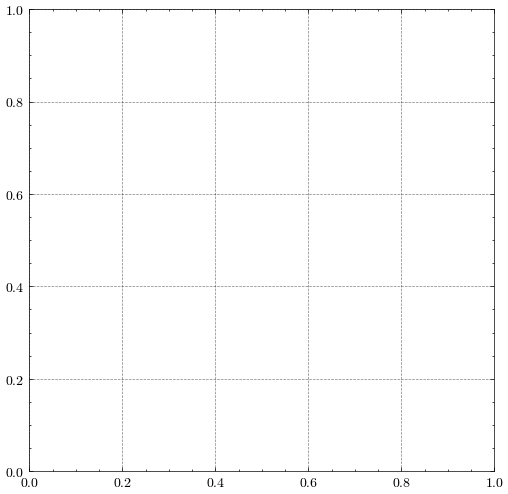

In [101]:
plt.figure(figsize=(6, 6))
# plot the relative error as a function of r and label each with the corresponding error tolerance
plt.plot(max_idx_lst[:-1], relative_error_window_lst, marker='o', label='Relative Error')

# mark the points with the corresponding snapshot energy
for i, txt in enumerate(err_tols[:-1]):
    plt.annotate(f"Eigval err: {txt:.4%}", (max_idx_lst[i], relative_error_window_lst[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("r")
plt.ylabel("Relative Error of Solution")
plt.title("Relative Error of Solution vs. Trucated dimension r, q=2")
plt.xticks(max_idx_lst)
plt.legend()

In [12]:
X_all_full = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")
relative_error_window_lst_vary_q = []
abs_error_full_lst_vary_q = []
energy_list_vary_q = []

q_trunc_lst = [2, 2**2, 2**3, 2**4, 2**5]
r = max_idx_lst[0]

for q_trunc_index in range(len(q_trunc_lst)):

    # Procustes problem for each mu
    X = np.concatenate([X_all[i, :, :] for i in range(Mp)], axis=0).T
    num_snapshots = X.shape[1]
    print("num_snapshots: ", num_snapshots)
    # print("X = ", X.shape)
    # X_ref = np.mean(X, axis=1)[:, None]
    X_ref = np.zeros((X.shape[0]))[:, None]
    X_centered = X - X_ref

    U, S, Vr = np.linalg.svd(X_centered, full_matrices=False)
    
    Vr = U[:, :r]
    Vbar = U[:, r:r+q_trunc_lst[q_trunc_index]]
    q = Vr.T @ X_centered
    Proj_error = X_centered - (Vr @ q)
    Poly = np.concatenate(polynomial_form(q, p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))

    Gamma_MPOD = X_ref + (Vr @ q) + (Vbar @ Xi @ Poly)
    print(f"Reconstruction error: {relative_error(X, Gamma_MPOD, X_ref):.4%}")
    
    energy = np.linalg.norm(Vr @ q + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(X - X_ref, 'fro')**2
    print(f"Energy: {energy:.4e}")
    print("\n")
    
    energy_list_vary_q.append(energy)

    # Mp = len(mus)
    # Nsnapshots = X.shape[1]
    # dShatdt = []
    # Shat_lst = []
    # dSdt = []
    # for j in range(Mp):
    #     start_ind = int((j) * Nsnapshots/Mp)
    #     end_ind = int((j+1) * Nsnapshots/Mp)
    #     print("start_ind: ", start_ind)
    #     print("end_ind: ", end_ind)
    #     ddtshat, ind = ddt(q[:, start_ind:end_ind], dt=dt, scheme='BE')
    #     ddts, ind = ddt(X[:, start_ind:end_ind], dt=dt, scheme="BE")
    #     dShatdt.append(ddtshat)
    #     ind = np.array(ind) + int((j) * Nsnapshots/Mp)
    #     Shat_lst.append(q[:, ind])
    #     dSdt.append(ddts)
        
    
    # def initial_condition(coord):
    #     if coord <= 0.5:
    #         return np.sin(2 * np.pi * coord)
        
    #     return 0

    # # update config file with truncation order r
    # config['robparams'] = {
    #     "r": int(r)
    # }

    # Shat_py = np.concatenate(Shat_lst, axis=1)
    # dShatdt_py = np.concatenate(dShatdt, axis=1).T
    # dSdt_py = np.hstack(dSdt)

    # print("Shape of Shat_py: ", Shat_py.shape)
    # print("Shape of dShatdt_py: ", dShatdt_py.shape)
    # # [operators] = inferOperators_NL(Shat, U, params, dShatdt);

    # operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
    # # operators = infer_operators_nl(q, None, config['params'], /dShatdt_py)
    
    # config['robparams'] = {
    # "r": int(r)
    # }

    # N = int(config['N'])
    # dt = config['dt']
    # T_end = config['T_end']
    # mus = config['mus']  # Assuming mus is saved as a string that represents a Python expression
    # Mp = config['Mp']
    # K = int(config['K'])
    # DS = config['DS']
    # params = config['params']  # This will be a dictionary in Python
    # robparams = config['robparams']  # This will be a dictionary in Python


    # coord = np.linspace(0, 1, N)
    # print("coord = ", coord.shape)
    # IC = np.array([initial_condition(c) for c in coord])
    # q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
    # time_domain = np.arange(0, T_end, dt)
    # train_size = Shat_py.shape[1]

    # # regs = [1e1, 3e3, 1e9]
    # # regs = [0.001, 20, 1e5]
    # Shat_true = Shat_lst[2]
    # regs_product = [1e-3, 1e-3, 1, 1e1, 1e4, 5, 1e3, 1e7, 5]
    # # regs_product = [1e-3, 1e-3, 1, 23, 60, 10]
    # # regs_product = [1e-3, 1e-2, 5, 1e-3, 1e-2, 5, 1e-3, 1e-1, 5]
    # # regs, operators = train_minimize(Shat_py, dShatdt_py, Shat_true, train_size, r, regs, time_domain, q0, params, testsize=None, margin=1.1)
    # regs, errors = train_gridsearch(Shat_py, dShatdt_py, Shat_true, train_size, r, regs_product, time_domain, q0, params, testsize=None, margin=1.1)


    # config['robparams'] = {
    # "r": int(r)
    # }

    # N = int(config['N'])
    # dt = config['dt']
    # T_end = config['T_end']
    # mus = config['mus']  # Assuming mus is saved as a string that represents a Python expression
    # Mp = config['Mp']
    # K = int(config['K'])
    # DS = config['DS']
    # params = config['params']  # This will be a dictionary in Python
    # robparams = config['robparams']  # This will be a dictionary in Python


    # coord = np.linspace(0, 1, N)
    # print("coord = ", coord.shape)
    # IC = np.array([initial_condition(c) for c in coord])
    # q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
    # time_domain = np.arange(0, T_end, dt)
    # train_size = Shat_py.shape[1]

    # # regs = [1e1, 3e3, 1e9]
    # # regs = [0.001, 20, 1e5]
    # Shat_true = Shat_lst[2]
    # regs_product = [1e-3, 1e-3, 1, 1e1, 1e4, 5, 1e3, 1e7, 5]
    # # regs_product = [1e-3, 1e-3, 1, 23, 60, 10]
    # # regs_product = [1e-3, 1e-2, 5, 1e-3, 1e-2, 5, 1e-3, 1e-1, 5]
    # # regs, operators = train_minimize(Shat_py, dShatdt_py, Shat_true, train_size, r, regs, time_domain, q0, params, testsize=None, margin=1.1)
    # regs, errors = train_gridsearch(Shat_py, dShatdt_py, Shat_true, train_size, r, regs_product, time_domain, q0, params, testsize=None, margin=1.1)
    
    # params['lambda1'] = regs[0]
    # params['lambda2'] = regs[1]
    # if len(regs) > 2:
    #     params['lambda3'] = regs[2]

    # operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
    
    
    # # compute the full time series
    # coord = np.linspace(0, 1, N)
    # print("coord = ", coord.shape)
    # IC = np.array([initial_condition(c) for c in coord])
    # q0 = Vr.T @ (IC[:, None] - X_ref).flatten()

    # T_end_full = 8
    # time_domain_full = np.arange(0, T_end_full, dt)

    # multi_indices = generate_multi_indices_efficient(len(q0), p=p)


    # modelform = config['params']['modelform']
    # out_full = scipy.integrate.solve_ivp(
    #             rhs,  # Integrate this function
    #             [time_domain_full[0], time_domain_full[-1]],  # over this time interval
    #             q0,  # from this initial condition
    #             t_eval=time_domain_full,  # evaluated at these points
    #             args=[operators, multi_indices, modelform, None],  # additional arguments to rhs
                
    #         )

    # s_hat_full = out_full.y
    # poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
    # print("Poly shape: ", poly_full.shape)

    # s_rec_full = X_ref + Vr @ s_hat_full + Vbar @ Xi @ poly_full
    
    
    # abs_error_full = np.abs(X_all_full[2].T - s_rec_full)
    # relative_error_window = np.linalg.norm(X_all_full[2].T[:, T_end:] - s_rec_full[:, T_end:], 'fro') / np.linalg.norm(X_all_full[2].T[:, T_end:], 'fro')
    
    # abs_error_full_lst_vary_q.append(abs_error_full)
    # relative_error_window_lst_vary_q.append(relative_error_window)

        

num_snapshots:  10005
Reconstruction error: 25.1568%
Energy: 9.3671e-01


num_snapshots:  10005
Reconstruction error: 25.1464%
Energy: 9.3677e-01


num_snapshots:  10005
Reconstruction error: 25.1461%
Energy: 9.3677e-01


num_snapshots:  10005
Reconstruction error: 25.1460%
Energy: 9.3677e-01


num_snapshots:  10005
Reconstruction error: 25.1460%
Energy: 9.3677e-01




In [13]:
energy_list_vary_q

[0.9367135019490238,
 0.936765726627382,
 0.936767515040487,
 0.9367676952337121,
 0.9367677101481616]

In [ ]:
plt.figure(figsize=(6, 6))
# plot the relative error as a function of q_trunc and label each with the corresponding Energy
plt.plot(q_trunc_lst, relative_error_window_lst_vary_q, marker='o', label='Relative Error of Solution')

# mark the points with the corresponding snapshot energy
for i, txt in enumerate(energy_list_vary_q):
    plt.annotate(f"Energy: {txt:.4%}", (q_trunc_lst[i], relative_error_window_lst_vary_q[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("r")
plt.ylabel("Relative Error of Solution")
plt.title("Relative Error of Solution vs. q for r=4, Eigval err=1e-1")
plt.xticks(q_trunc_lst)
# plt.ylim([0.48, 0.51])
plt.legend()